In [1180]:
''' Import libraries '''
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import optimize as opt
import math

## Config

In [1181]:
# path = '/home/phw93/dev/calib/data/*.jpg'
path = '/home/phw/dev/calib/data/*.jpg'

checkboard = [8,6] # height, width
boardSize = 2
real_coor = np.zeros((checkboard[0] * checkboard[1], 3), np.float32)
real_coor[:, :2] = np.mgrid[0:checkboard[0], 0:checkboard[1]].T.reshape(-1, 2) * boardSize
visualize_en = 1 # 0 off, 1 on
real_points = []
real_points_x_y = []

## Functions

In [1182]:


def load_images(path):
    """
    images path를 입력받아 load 하고, images와 gray images를 리턴합니다.
    """
    image_files = glob.glob(path)
    image_files = sorted(image_files)
    images = []
    gray_images = []
    for image_file in image_files:
        image = cv2.imread(image_file)
        # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        images.append(image)
        gray_images.append(gray_image)

    # check 
    images_len = len(gray_images)
    w, h = gray_images[2].shape
    print("Width, Height: ",w, h)
    print("Image len: ", images_len)
    print("Checker board size: ",checkboard[0], checkboard[1])
    print('------')
    
    return images, gray_images
    

In [1230]:
def extract_corner_and_NMS(images, gray_images):
    # extract corner & NMS
    """
    gray image의 corner들을 검출하여 arrCorners Array에 
    [[x1,y1], [x2, x2]... ]로 담아 리턴
    """
    arrCorners = []
    selectedImg = []
    selectedGrayImg = []
    imgIdx = []
    window_size = 3
    half_size = window_size // 2
    winSize = (window_size*2+1, window_size*2+1)
    zeroZone = (-1, -1)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    for i in range(len(gray_images)):
        max_corners = 100   # 최대 코너 개수
        quality_level = 0.01  # 코너 품질 임계값 (0 ~ 1 사이의 값)
        min_distance = 10  # 검출된 코너 간의 최소 거리
        mask = np.empty((0, 0), dtype=np.float32)
        # corners = cv2.goodFeaturesToTrack(gray_image, max_corners, quality_level, min_distance, mask, blockSize=3, useHarrisDetector=True, k=0.04)
        temp = cv2.convertScaleAbs(gray_images[i])  # 이미지를 8비트로 변환
        ret, corners = cv2.findChessboardCorners(temp, checkboard, None)
        if ret == True:
            refined_corners = cv2.cornerSubPix(gray_images[i], corners, winSize, zeroZone, criteria)
            refined_corners = refined_corners.reshape(-1,2)
            arrCorners.append(refined_corners)
            selectedImg.append(images[i])
            selectedGrayImg.append(gray_images[i])
            imgIdx.append(i)
            
    return selectedImg, selectedGrayImg , arrCorners, imgIdx

In [1231]:
def filter_corners(images, gray_images, imgIdx, arrCorners, real_points, real_points_x_y, threshold, checkboard):
    # draw corners
    filtImg = []
    filtGrayImg = []
    filtCorners = []
    filtIdx = []
    for image, gray_image, corners, idx in zip(images, gray_images, arrCorners, imgIdx):
        if(len(corners)>=(checkboard[0] * checkboard[1] + 3 * (checkboard[0] + checkboard[1]))):
            continue    
        temp = image.copy()
        mean = np.mean(corners, axis=0)
        variance = np.var(corners, axis=0)
        # 분산을 기준으로 일정 이내에 있는 포인트들 필터링
#         threshold = 1.3  # 일정 분산 임계값 (조정 가능)
        filtered_points = []
        for corner in corners:
            if np.all(np.abs(corner - mean) <= threshold * np.sqrt(variance)):
                filtered_points.append(corner)
                x, y = corner[0].astype(int), corner[1].astype(int)
                if(visualize_en):
                    cv2.drawMarker(temp, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_STAR, markerSize=10, thickness=3)
        if(len(filtered_points) == checkboard[0] * checkboard[1]):
            filtCorners.append(filtered_points)
            filtImg.append(temp)
            filtGrayImg.append(gray_image)
            filtIdx.append(idx)
            real_points.append(real_coor)
            real_points_x_y.append(real_coor[:, :2])
    
    return filtImg, filtGrayImg, filtCorners, filtIdx
    

In [1232]:
def draw_corners(n, filtImg, filtCorners):
    # 이미지 표시
    plt.imshow(filtImg[n], cmap='gray')
    print("selected images count: ", len(filtCorners))
    print("found corner count: ", len(filtCorners[n]))


### Zhang's method Functions
Ref: https://github.com/SPengLiang/Camera-Calibration-of-Zhang-s-method/tree/master

In [1186]:
# Get Distortion
def get_distortion(intrinsic_param, extrinsic_param, pic_coor, real_coor):
    D = []
    d = []
    for i in range(len(pic_coor)):
        for j in range(len(pic_coor[i])):
            # homogeneous 좌표로 변환
            single_coor = np.array([(real_coor[i])[j, 0], (real_coor[i])[j, 1], 0, 1])

            # 기존 내부 및 외부 매개변수를 사용하여 추정 이미지 좌표 찾기
            u = np.dot(np.dot(intrinsic_param, extrinsic_param[i]), single_coor)
            [u_estim, v_estim] = [u[0]/u[2], u[1]/u[2]]

            coor_norm = np.dot(extrinsic_param[i], single_coor)
            coor_norm /= coor_norm[-1]

            #r = np.linalg.norm((real_coor[i])[j])
            r = np.linalg.norm(coor_norm)


            D.append(np.array([(u_estim - intrinsic_param[0, 2]) * r ** 2, (u_estim - intrinsic_param[0, 2]) * r ** 4]))
            D.append(np.array([(v_estim - intrinsic_param[1, 2]) * r ** 2, (v_estim - intrinsic_param[1, 2]) * r ** 4]))

            # 추정 좌표와 실제 좌표 사이의 잔차 찾기
            d.append(pic_coor[i][j, 0] - u_estim)
            d.append(pic_coor[i][j, 1] - v_estim)

    D = np.array(D)
    temp = np.dot(np.linalg.inv(np.dot(D.T, D)), D.T)
    k = np.dot(temp, d)

    return k

In [1187]:
# Get Extrinsic
def get_extrinsics_param(H, intrinsics_param):
    extrinsics_param = []

    inv_intrinsics_param = np.linalg.inv(intrinsics_param)
    for i in range(len(H)):
        h0 = (H[i].reshape(3, 3))[:, 0]
        h1 = (H[i].reshape(3, 3))[:, 1]
        h2 = (H[i].reshape(3, 3))[:, 2]

        scale_factor = 1 / np.linalg.norm(np.dot(inv_intrinsics_param, h0))

        r0 = scale_factor * np.dot(inv_intrinsics_param, h0)
        r1 = scale_factor * np.dot(inv_intrinsics_param, h1)
        t = scale_factor * np.dot(inv_intrinsics_param, h2)
        r2 = np.cross(r0, r1)

        R = np.array([r0, r1, r2, t]).transpose()
        extrinsics_param.append(R)

    return extrinsics_param

In [1188]:
# Homography Function
def normalizing_input_data(coor_data):

    coor_data = np.array(coor_data)
    x_avg = np.mean(coor_data[:, 0])
    y_avg = np.mean(coor_data[:, 1])
    sx = np.sqrt(2) / np.std(coor_data[:, 0])
    sy = np.sqrt(2) / np.std(coor_data[:, 1])

    norm_matrix = np.matrix([[sx, 0, -sx * x_avg],
                             [0, sy, -sy * y_avg],
                             [0, 0, 1]])
    return norm_matrix


# 초기 추정치에 대한 호모그래피 행렬 찾기
def get_initial_H(pic_coor, real_coor):
    # 행렬 정규화
    pic_norm_mat = normalizing_input_data(pic_coor)
    real_norm_mat = normalizing_input_data(real_coor)

    M = []
    for i in range(len(pic_coor)):
        # homogeneous coordinate으로 변환
        single_pic_coor = np.array([pic_coor[i][0], pic_coor[i][1], 1])
        single_real_coor = np.array([real_coor[i][0], real_coor[i][1], 1])

        # 좌표 normalize
        pic_norm = np.dot(pic_norm_mat, single_pic_coor)
        real_norm = np.dot(real_norm_mat, single_real_coor)

        # M 행렬 구성
        M.append(np.array([-real_norm.item(0), -real_norm.item(1), -1,
                      0, 0, 0,
                      pic_norm.item(0) * real_norm.item(0), pic_norm.item(0) * real_norm.item(1), pic_norm.item(0)]))

        M.append(np.array([0, 0, 0,
                      -real_norm.item(0), -real_norm.item(1), -1,
                      pic_norm.item(1) * real_norm.item(0), pic_norm.item(1) * real_norm.item(1), pic_norm.item(1)]))

    # SVD를 사용하여 M*h=0에서 h에 대한 해를 구합니다.
    U, S, VT = np.linalg.svd((np.array(M, dtype='float')).reshape((-1, 9)))
    # 가장 작은 특이값에 해당하는 특이 벡터 S를 계산하여 크기에 따라 배열하고 최종적으로 가장 작은 특이값을
    H = VT[-1].reshape((3, 3))
    H = np.dot(np.dot(np.linalg.inv(pic_norm_mat), H), real_norm_mat)
    H /= H[-1, -1]

    return H


# 추정 좌표와 실제 좌표 간의 편차를 반환합니다.
def value(H, pic_coor, real_coor):
    Y = np.array([])
    for i in range(len(real_coor)):
        single_real_coor = np.array([real_coor[i, 0], real_coor[i, 1], 1])
        U = np.dot(H.reshape(3, 3), single_real_coor)
        U /= U[-1]
        Y = np.append(Y, U[:2])

    Y_NEW = (pic_coor.reshape(-1) - Y)

    return Y_NEW


# 해당 jacobian 행렬을 반환합니다.
def jacobian(H, pic_coor, real_coor):
    J = []
    for i in range(len(real_coor)):
        sx = H[0]*real_coor[i][0] + H[1]*real_coor[i][1] +H[2]
        sy = H[3]*real_coor[i][0] + H[4]*real_coor[i][1] +H[5]
        w = H[6]*real_coor[i][0] + H[7]*real_coor[i][1] +H[8]
        w2 = w * w

        J.append(np.array([real_coor[i][0]/w, real_coor[i][1]/w, 1/w,
                           0, 0, 0,
                           -sx*real_coor[i][0]/w2, -sx*real_coor[i][1]/w2, -sx/w2]))

        J.append(np.array([0, 0, 0,
                           real_coor[i][0]/w, real_coor[i][1]/w, 1/w,
                           -sy*real_coor[i][0]/w2, -sy*real_coor[i][1]/w2, -sy/w2]))

    return np.array(J)


# Levenberg Marquart 알고리즘을 사용하여 H 미세 조정
def refine_H(pic_coor, real_coor, initial_H):
    initial_H = np.array(initial_H)
    final_H = opt.leastsq(value,
                          initial_H,
                          Dfun=jacobian,
                          args=(pic_coor, real_coor))[0]

    final_H /= np.array(final_H[-1])
    return final_H


# 미세 조정된 H를 반환합니다.
def get_homography(pic_coor, real_coor):
    refined_homographies =[]

    error = []
    for i in range(len(pic_coor)):
        initial_H = get_initial_H(pic_coor[i], real_coor[i])
        final_H = refine_H(pic_coor[i], real_coor[i], initial_H)
        refined_homographies.append(final_H)

    return np.array(refined_homographies)

In [1189]:
# Get Intrinsic
# pq 위치에 해당하는 v 벡터를 반환합니다.
def create_v(p, q, H):
    H = H.reshape(3, 3)
    return np.array([
        H[0, p] * H[0, q],
        H[0, p] * H[1, q] + H[1, p] * H[0, q],
        H[1, p] * H[1, q],
        H[2, p] * H[0, q] + H[0, p] * H[2, q],
        H[2, p] * H[1, q] + H[1, p] * H[2, q],
        H[2, p] * H[2, q]
    ])


# 카메라 내부 매개변수 행렬 A 반환
def get_intrinsics_param(H):
    # V 매트릭스 구축
    V = np.array([])
    for i in range(len(H)):
        V = np.append(V, np.array([create_v(0, 1, H[i]), create_v(0, 0 , H[i])- create_v(1, 1 , H[i])]))

    # V*b = 0에서 b에 대해 풀기
    U, S, VT = np.linalg.svd((np.array(V, dtype='float')).reshape((-1, 6)))
    # 가장 작은 특이값에 해당하는 벡터 S를 계산하여 크기에 따라 배열하고 최종적으로 가장 작은 특이값을 초기화
    b = VT[-1]

    # 카메라의 내부 매개변수 찾기
    w = b[0] * b[2] * b[5] - b[1] * b[1] * b[5] - b[0] * b[4] * b[4] + 2 * b[1] * b[3] * b[4] - b[2] * b[3] * b[3]
    d = b[0] * b[2] - b[1] * b[1]

    alpha = np.sqrt(w / (d * b[0]))
    beta = np.sqrt(w / d**2 * b[0])
    gamma = np.sqrt(w / (d**2 * b[0])) * b[1]
    uc = (b[1] * b[4] - b[2] * b[3]) / d
    vc = (b[1] * b[3] - b[0] * b[4]) / d

    return np.array([
        [alpha, gamma, uc],
        [0,     beta,  vc],
        [0,     0,      1]
    ])


In [1190]:
# 모든 포인트의 실제 좌표가 실제 이미지 좌표에 매핑된 이미지 좌표의 잔차를 반환합니다.
def value(P, org_W, X, Y_real):
    M = (len(P) - 7) // 6
    N = len(X[0])
    A = np.array([
        [P[0], P[2], P[3]],
        [0, P[1], P[4]],
        [0, 0, 1]
    ])
    Y = np.array([])

    for i in range(M):
        m = 7 + 6 * i

        # 현재 이미지에 해당하는 외부 매개변수 가져오기
        w = P[m:m + 6]

        # 회전 행렬이 없는 변환은 정밀도 손실 때문입니다.
        '''
        R = to_rotation_matrix(w[:3])
        t = w[3:].reshape(3, 1)
        W = np.concatenate((R, t), axis=1)
        '''
        W = org_W[i]
        # 각 플롯에 대한 좌표 잔차 계산
        for j in range(N):
            Y = np.append(Y, get_single_project_coor(A, W, np.array([P[5], P[6]]), (X[i])[j]))

    error_Y  =  np.array(Y_real).reshape(-1) - Y

    return error_Y

# Refine All
def refinall_all_param(A, k, W, real_coor, pic_coor):
    # 통합 매개변수
    P_init = compose_paramter_vector(A, k, W)

    # 실제 좌표의 복사본 복사
    X_double = np.zeros((2 * len(real_coor) * len(real_coor[0]), 3))
    Y = np.zeros((2 * len(real_coor) * len(real_coor[0])))

    M = len(real_coor)
    N = len(real_coor[0])
    for i in range(M):
        for j in range(N):
            X_double[(i * N + j) * 2] = (real_coor[i])[j]
            X_double[(i * N + j) * 2 + 1] = (real_coor[i])[j]
            Y[(i * N + j) * 2] = (pic_coor[i])[j, 0]
            Y[(i * N + j) * 2 + 1] = (pic_coor[i])[j, 1]

    # 모든 매개변수 미세 조정
    P = opt.leastsq(value,
                    P_init,
                    args=(W, real_coor, pic_coor),
                    Dfun=jacobian)[0]

    # Radial_error는 보정된 매개변수를 사용하여 계산된 이미지 좌표와 실제 이미지 좌표점 사이의 평균 픽셀 거리를 나타냅니다.
    error = value(P, W, real_coor, pic_coor)
    raial_error = [np.sqrt(error[2 * i]**2 + error[2 * i + 1]**2) for i in range(len(error) // 2)]

    print("total max error:\t", np.max(raial_error))

    # 내부 참조 행렬, 왜곡 보정 계수 및 각 이미지는 외부 매개 변수 행렬에 해당하는 분해 후 매개 변수를 반환합니다.
    return decompose_paramter_vector(P)


# 모든 매개변수를 배열로 결합
def compose_paramter_vector(A, k, W):
    alpha = np.array([A[0, 0], A[1, 1], A[0, 1], A[0, 2], A[1, 2], k[0], k[1]])
    P = alpha
    for i in range(len(W)):
        R, t = (W[i])[:, :3], (W[i])[:, 3]

        # 회전 행렬을 1D 벡터 형식으로 변환
        zrou = to_rodrigues_vector(R)

        w = np.append(zrou, t)
        P = np.append(P, w)
    return P


# 매개변수 세트를 분해하여 해당 내부 매개변수, 외부 매개변수 및 왜곡 보정 계수를 얻습니다.
def decompose_paramter_vector(P):
    [alpha, beta, gamma, uc, vc, k0, k1] = P[0:7]
    A = np.array([[alpha, gamma, uc],
                  [0, beta, vc],
                  [0, 0, 1]])
    k = np.array([k0, k1])
    W = []
    M = (len(P) - 7) // 6

    for i in range(M):
        m = 7 + 6 * i
        zrou = P[m:m+3]
        t = (P[m+3:m+6]).reshape(3, -1)

        # 회전 행렬 1D 벡터 형식을 행렬 형식으로 복원
        R = to_rotation_matrix(zrou)

        # 각 그림의 외부 매개변수를 차례로 스티칭
        w = np.concatenate((R, t), axis=1)
        W.append(w)

    W = np.array(W)
    return A, k, W


# 실제 좌표에서 매핑된 이미지 좌표를 반환합니다.
def get_single_project_coor(A, W, k, coor):
    single_coor = np.array([coor[0], coor[1], coor[2], 1])

    #'''
    coor_norm = np.dot(W, single_coor)
    coor_norm /= coor_norm[-1]

    #r = np.linalg.norm(coor)
    r = np.linalg.norm(coor_norm)

    uv = np.dot(np.dot(A, W), single_coor)
    uv /= uv[-1]

    # 왜곡
    u0 = uv[0]
    v0 = uv[1]

    uc = A[0, 2]
    vc = A[1, 2]

    #u = (uc * r**2 * k[0] + uc * r**4 * k[1] - u0) / (r**2 * k[0] + r**4 * k[1] - 1)
    #v = (vc * r**2 * k[0] + vc * r**4 * k[1] - v0) / (r**2 * k[0] + r**4 * k[1] - 1)
    u = u0 + (u0 - uc) * r**2 * k[0] + (u0 - uc) * r**4 * k[1]
    v = v0 + (v0 - vc) * r**2 * k[0] + (v0 - vc) * r**4 * k[1]

    return np.array([u, v])





# 해당 jacobian 행렬을 계산합니다.
def jacobian(P, WW, X, Y_real):
    M = (len(P) - 7) // 6
    N = len(X[0])
    K = len(P)
    A = np.array([
        [P[0], P[2], P[3]],
        [0, P[1], P[4]],
        [0, 0, 1]
    ])

    res = np.array([])

    for i in range(M):
        m = 7 + 6 * i

        w = P[m:m + 6]
        R = to_rotation_matrix(w[:3])
        t = w[3:].reshape(3, 1)
        W = np.concatenate((R, t), axis=1)

        for j in range(N):
            res = np.append(res, get_single_project_coor(A, W, np.array([P[5], P[6]]), (X[i])[j]))

    # x 및 y 방향에서 P[k]의 편미분 찾기
    J = np.zeros((K, 2 * M * N))
    for k in range(K):
        J[k] = np.gradient(res, P[k])

    return J.T


# 회전 행렬을 벡터로 분해하여 반환합니다 로드리게스 회전 벡터와 행렬 변환은 정밀도의 손실이 있기 때문에 좌표의 최종 계산에 사용되지 않습니다
def to_rodrigues_vector(R):
    p = 0.5 * np.array([[R[2, 1] - R[1, 2]],
                        [R[0, 2] - R[2, 0]],
                        [R[1, 0] - R[0, 1]]])
    c = 0.5 * (np.trace(R) - 1)

    if np.linalg.norm(p) == 0:
        if c == 1:
            zrou = np.array([0, 0, 0])
        elif c == -1:
            R_plus = R + np.eye(3, dtype='float')

            norm_array = np.array([np.linalg.norm(R_plus[:, 0]),
                                   np.linalg.norm(R_plus[:, 1]),
                                   np.linalg.norm(R_plus[:, 2])])
            v = R_plus[:, np.where(norm_array == max(norm_array))]
            u = v / np.linalg.norm(v)
            if u[0] < 0 or (u[0] == 0 and u[1] < 0) or (u[0] == u[1] and u[0] == 0 and u[2] < 0):
                u = -u
            zrou = math.pi * u
        else:
            zrou = []
    else:
        u = p / np.linalg.norm(p)
        theata = math.atan2(np.linalg.norm(p), c)
        zrou = theata * u

    return zrou


# 회전 행렬의 1차원 벡터 형태를 회전 행렬로 복원하고 반환
def to_rotation_matrix(zrou):
    theta = np.linalg.norm(zrou)
    zrou_prime = zrou / theta

    W = np.array([[0, -zrou_prime[2], zrou_prime[1]],
                  [zrou_prime[2], 0, -zrou_prime[0]],
                  [-zrou_prime[1], zrou_prime[0], 0]])
    R = np.eye(3, dtype='float') + W * math.sin(theta) + np.dot(W, W) * (1 - math.cos(theta))

    return R

In [1191]:
# # Calibration
# def calibrate(filtCorners, real_points, real_points_x_y):
#     intrinsic = []
#     distortion = []
#     extrinsic = []
#     # 호모그래피 행렬 찾기
#     for i in range(len(filtCorners)):
#         H = get_homography(filtCorners[i], real_points_x_y[i])

#         # 내부 참조 찾기
#         intrinsics_param = get_intrinsics_param(H)

#         # 각 그림에 해당하는 외부 매개변수 찾기
#         extrinsics_param = get_extrinsics_param(H, intrinsics_param)

#         # 왜곡 보정
#         k = get_distortion(intrinsics_param, extrinsics_param, filtCorners[i], real_points_x_y[i])

#         # 모든 매개변수 미세 조정
#         [new_intrinsics_param, new_k, new_extrinsics_param]  = refinall_all_param(intrinsics_param,
#                                                                 k, extrinsics_param, real_points[i], filtCorners[i])
#         intrinsic.append(new_intrinsics_param)
#         extrinsic.append(new_extrinsics_param)
#         distortion.append(new_k)
#         print("intrinsics_parm:\t", new_intrinsics_param)
#         print("distortionk:\t", new_k)
#         print("extrinsics_parm:\t", new_extrinsics_param)
#     return intrinsic, extrinsic, distortion

# Calibration
def calibrate(filtCorners, real_points, real_points_x_y):
    intrinsic = []
    distortion = []
    extrinsic = []
    # 호모그래피 행렬 찾기
    H = get_homography(filtCorners, real_points_x_y)

    # 내부 참조 찾기
    intrinsics_param = get_intrinsics_param(H)

    # 각 그림에 해당하는 외부 매개변수 찾기
    extrinsics_param = get_extrinsics_param(H, intrinsics_param)

    # 왜곡 보정
    k = get_distortion(intrinsics_param, extrinsics_param, filtCorners, real_points_x_y)

    # 모든 매개변수 미세 조정
    [new_intrinsics_param, new_k, new_extrinsics_param]  = refinall_all_param(intrinsics_param,
                                                            k, extrinsics_param, real_points, filtCorners)
    intrinsic.append(new_intrinsics_param)
    extrinsic.append(new_extrinsics_param)
    distortion.append(new_k)
    print("intrinsics_parm:\t", new_intrinsics_param)
    print("distortionk:\t", new_k)
    print("extrinsics_parm:\t", new_extrinsics_param)
    return intrinsic, extrinsic, distortion
        

### Matching Functions

In [1228]:
def distance_from_origin(point):
    return math.sqrt(point[0]**2 + point[1]**2)

def distance(point1, point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def find_closest_points(points, reference_point, k=2):
    sorted_points = sorted(points, key=lambda point: distance(point, reference_point))
    return sorted_points[1:k+1]  # 첫 번째 포인트는 자기 자신이므로 제외하고 반환

def compute_direction_vec(reference_point, closest_point):
    direction_vector = (closest_point[0] - reference_point[0], closest_point[1] - reference_point[1])
    return direction_vector

def direction_vec_esti(closest_points, reference_point):
    direction_vector = (closest_points[0] - reference_point[0], closest_points[1] - reference_point[1])
    return direction_vector

def normalize_vector(vector):
    magnitude = math.sqrt(vector[0]**2 + vector[1]**2)
    normalized_vector = (vector[0] / magnitude, vector[1] / magnitude)
    return normalized_vector

def dot_product(vector1, vector2):
    return vector1[0] * vector2[0] + vector1[1] * vector2[1]

def matching(filtImgs, filtCorners, disthresh = 0.8):
    sortedMatching = []
    tempImgs = []
    for i in range(len(filtCorners)):
        sorted_corners = sorted(filtCorners[i], key=lambda k: (k[0], k[1]))
        # sorted_by_x_and_distance = sorted(sorted_corners, key=lambda k: (distance_from_origin(k)))
        # for j in range(len(sorted_by_x_and_distance)):
        #     print(sorted_by_x_and_distance[j])
        # refer = sorted_by_x_and_distance[:3]
        reference_point = min(filtCorners[i], key=lambda point: point[0])
        closest_points = find_closest_points(sorted_corners, reference_point, k=2)
        closest_points = sorted(closest_points, key=lambda k: k[1])
        esti_vec0 = direction_vec_esti(closest_points[0], reference_point)
        esti_vec1 = direction_vec_esti(closest_points[1], reference_point)
        norm_close0 = normalize_vector(esti_vec0)
        norm_close1 = normalize_vector(esti_vec1)
        # print(norm_close0, norm_close1)
        # print('dot_product closest: ', abs(dot_product(norm_close0, norm_close1)), i)
        if(abs(dot_product(norm_close0, norm_close1)) > 0.7):
            continue            
        esti_vec = direction_vec_esti(closest_points[0], reference_point)
        norm_vec = normalize_vector(esti_vec)
        product_vec = dot_product(norm_vec, (1,0))
        # print('ref: ',reference_point[0], reference_point[1], 'close: ', closest_points[0][0], closest_points[0][1],', ', closest_points[1][0], closest_points[1][1])
        # print('esti: ', esti_vec, 'norm: ', norm_vec, 'product: ', product_vec, i)
        
        temp = np.copy(filtImgs[i])
        if(visualize_en):
            cv2.drawMarker(temp, (reference_point[0].astype(int), reference_point[1].astype(int)), color=(0, 255, 0), markerType=cv2.MARKER_STAR, markerSize=10, thickness=5)
            cv2.drawMarker(temp, (closest_points[0][0].astype(int), closest_points[0][1].astype(int)), color=(255, 0, 0), markerType=cv2.MARKER_STAR, markerSize=10, thickness=5)
            cv2.drawMarker(temp, (closest_points[1][0].astype(int), closest_points[1][1].astype(int)), color=(255, 0, 0), markerType=cv2.MARKER_STAR, markerSize=10, thickness=5)
            cv2.putText(temp, "ref", (int(reference_point[0])-10, int(reference_point[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
            cv2.putText(temp, "clos0", (int(closest_points[0][0])-10, int(closest_points[0][1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
            cv2.putText(temp, "clos1", (int(closest_points[1][0])-10, int(closest_points[1][1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
        if(product_vec > 0.999):
            ''' case 1 '''
            sortedMatching.append(sorted_corners)
            tempImgs.append(temp)
            print('case 1', i)
            
        else:
            ''' case 2 & 3 '''
            tempCorners = []
            sortedMatching.append(sorted_corners)
            tempImgs.append(temp)
            rep=0
            tempRefPoint = np.array([reference_point[0], reference_point[1]])
            tempCorners.append(reference_point)
            esti_vec_mag = distance_from_origin(esti_vec)
            print(esti_vec_mag)
            while(True):
                tempRefPoint[0] += esti_vec[0]
                tempRefPoint[1] += esti_vec[1]
                next_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - tempRefPoint[0])**2 + (point[1] - tempRefPoint[1])**2))
                tempNextPoint = np.array([next_point[0], next_point[1]])

                distance = math.sqrt((tempNextPoint[0] - tempRefPoint[0])**2 + (tempNextPoint[1] - tempRefPoint[1])**2)
                print('nextPoint: ', tempNextPoint, 'reference: ', tempRefPoint, 'distance: ', distance, rep)
                rep += 1
                # print(distance)
                
                if distance <= esti_vec_mag * disthresh:
                    tempCorners.append(next_point)
                else:
                    if(len(tempCorners) == checkboard[1]):
                        print('case 2', i)
                        break
                    elif(len(tempCorners) == checkboard[0]):
                        print('case 3', i)
                        break
                    else:
                        print('error matching')
                        break
            
    
    return tempImgs, sortedMatching
        
    

# Run code

### IMAGE LOAD

In [1193]:
images, gray_images = load_images(path)

Width, Height:  1920 1080
Image len:  114
Checker board size:  8 6
------


### Feature extract

In [1194]:
images ,gray_images, arrCorners, imgIdx = extract_corner_and_NMS(images, gray_images)

In [1195]:
print(len(gray_images))

113


### Filtered Checkboard Corner

In [1196]:
filtImgs, filtGrayImgs, filtCorners, imgIdx= filter_corners(images, gray_images, imgIdx, arrCorners, real_points, real_points_x_y, 10, checkboard)


selected images count:  113
found corner count:  48
113


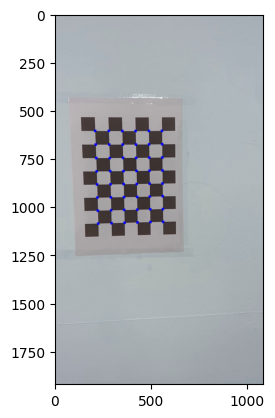

In [1197]:
draw_corners(0, filtImgs, filtCorners)
print(len(imgIdx))

### Matching

In [1227]:
# filtCorners = matching(filtImgs, filtCorners, 2.0)
filtImgs, filtCorners = matching(filtImgs, filtCorners, 0.8)

case 1 0
case 1 1
case 1 2
case 1 3
case 1 4
case 1 5
58.15267743525454
nextPoint:  [264.4258 621.9195] reference:  [264.4258 621.9195] distance:  0.0 0
nextPoint:  [319.01987 626.9084 ] reference:  [322.35132 627.0546 ] distance:  3.3346596143268608 1
nextPoint:  [371.1046  631.49164] reference:  [380.27682 632.18976] distance:  9.198740169251328 2
nextPoint:  [422.13617 635.59674] reference:  [438.20233 637.3249 ] distance:  16.158838613032852 3
nextPoint:  [470.42728 639.5311 ] reference:  [496.12784 642.46   ] distance:  25.86691483217382 4
nextPoint:  [470.42728 639.5311 ] reference:  [554.05334 647.59515] distance:  84.01397372931177 5
case 2 6
62.611187388727835
nextPoint:  [ 331.23917 1011.02136] reference:  [ 331.23917 1011.02136] distance:  0.0 0
nextPoint:  [332.52   948.0465] reference:  [332.3439 948.4199] distance:  0.41284835241742507 1
nextPoint:  [333.62637 884.49524] reference:  [333.44864 885.8185 ] distance:  1.3351252356376258 2
nextPoint:  [334.3742 820.4436] refe

selected images count:  112
found corner count:  48


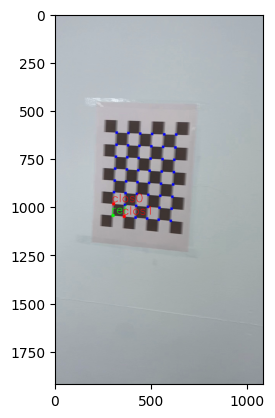

In [1229]:
draw_corners(14, filtImgs, filtCorners)

### Zhang's Method

In [1200]:
filtCorners = np.array(filtCorners)
real_points = np.array(real_points)
real_points_x_y = np.array(real_points_x_y)
intrinsic, extrinsic, distortion = calibrate(filtCorners, real_points, real_points_x_y)


TypeError: value() missing 1 required positional argument: 'Y_real'